In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder



from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression, RFECV


from tpot import TPOTRegressor

from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model, get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf
from main.components.feature_importance_methods import rename_importnace_col, merge_feature_importances, rank_importances


import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
917,4,NaN,NaN,NaN,56.5,165.0,20.752984,NaN,NaN,NaN,67.0,0.0,78.0,0.858974,1.0,1.0,0.406061,0.0,0.0,1.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.095952,2.327940,3.423892,NaN,NaN,7.38,13.22,20.60,1.0,0.0,0.0,5.77,2.70,2.29,0.54,0.19,0.05,46.7,39.7,9.4,3.3,0.9,4.41,13.4,3.4,0.253731,89.3,30.4,34.0,11.6,0.0,266.0,11.5,10.0,24.6,46.100520,0.037594,116.157205,4.240741,1.179039,0.396880,0.032929,141.0,3.97,10.50,NaN,0.86,NaN,11.0,16.0,NaN,158.0,4.08588,0.0,71.0,1.83606,0.0,86.0,2.223960,0.0,55.0,0.62095,0.0,1.211268,0.774648,0.560939,29.272727,5.58855,4.219075,-0.110896,NaN,NaN,NaN,NaN,NaN,84.0,88.0,8.76,NaN,1.816889,NaN,0.348823,0.0,0.0,0.84,5.24,20.20,9.0,14.0,3.1,15.0,4.838710,1235.0,273.0,1.96,0.564842,0.020851,743.571424,NaN,613.0,143.0,420.0,94.0,2.09,30.60,NaN,NaN,3.88,3.62,220.0,0.008909,0.505155,NaN,NaN,NaN
113,0,NaN,NaN,NaN,55.0,160.0,21.484375,120.0,78.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,1.0,NaN,NaN,1.0,20.669808,4.304773,24.974581,NaN,1.0,6.25,NaN,NaN,NaN,0.0,0.0,4.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.35,12.9,38.7,3.000000,89.0,29.7,33.3,12.0,0.0,221.0,14.3,11.4,36.7,47.323340,0.051584,NaN,NaN,NaN,NaN,NaN,140.0,4.59,4.98,NaN,0.68,NaN,12.0,13.0,0.32,199.0,5.14614,0.0,74.0,1.91364,0.0,105.7,2.733402,0.0,97.0,1.09513,0.0,1.428378,1.310811,NaN,NaN,NaN,4.548250,0.117540,NaN,NaN,NaN,NaN,NaN,92.0,104.0,8.15,72.67,1.851358,5.80,0.347833,0.0,0.0,1.27,4.77,15.90,10.0,359.0

<Axes: >

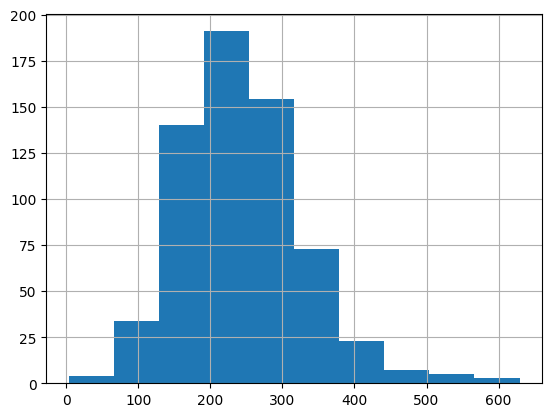

In [3]:
df[IGF].hist()

In [4]:
mean = df[IGF].mean()
std = df[IGF].std()
zscore_3_threshold = mean + (3*std)
df[df[IGF] > zscore_3_threshold][IGF]

82     574.0
327    508.0
483    512.0
565    504.0
574    604.0
729    527.0
853    629.0
884    543.0
Name: IGF-1 ng/ml (N: 100-311), dtype: float64

In [5]:
df.loc[df[IGF] > zscore_3_threshold, IGF] = np.nan

In [6]:
df_igf_cleaned = df.dropna(subset=[IGF])

X_igf, y_igf = df_igf_cleaned.drop(columns=[IGF]), df_igf_cleaned[IGF]
X_train_igf, X_test_igf, y_train_igf, y_test_igf = train_test_split(X_igf, y_igf, test_size=0.2, random_state=42)

## Models exploration

In [8]:
models = [
        DecisionTreeRegressor(max_depth=7, random_state=42),
        Lasso(),
        Ridge(),
        RandomForestRegressor(),
        ]

#  TODO: maybe add DropHighMissingColumns

continuous_preprocessings = {
    'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'PT_KNN': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
    'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
}

categorical_preprocessings = {
    # 'custom_ohe_no_imputing': Pipeline([('one_hot_encoder', CustomOneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True))]),
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}


scores_df = explore_all_variations_of_preprocessing(X_train_igf, y_train_igf, IGF, models, continuous_preprocessings, categorical_preprocessings)

1/48 DecisionTreeRegressor(max_depth=7, random_state=42) PT_iterative_basic original_ohe_no_imputing [-71.42146125 -86.52416007 -77.06086085 -77.6960309  -65.22213995
 -87.3326502  -58.35277079 -83.03002733 -70.28025084 -77.09305163
 -76.95734161 -82.85818702 -77.50083197 -83.84546095 -72.13991723] 76.48767617250061
2/48 Lasso() PT_iterative_basic original_ohe_no_imputing [-62.52149945 -63.48342818 -65.85754222 -60.98206036 -65.31404261
 -66.81839919 -56.15943523 -59.29320659 -58.85662724 -56.92910083
 -60.70163767 -59.81683253 -65.05162081 -67.81602926 -57.19351234] 61.78633163531215
3/48 Ridge() PT_iterative_basic original_ohe_no_imputing [-73.49539945 -70.89918795 -74.99311633 -74.08460496 -92.25250736
 -75.27847961 -71.95463176 -67.30198561 -77.03922909 -64.10302008
 -63.02234735 -72.16719286 -77.2903278  -79.02278674 -65.2463899 ] 73.21008045694856
4/48 RandomForestRegressor() PT_iterative_basic original_ohe_no_imputing [-60.39617647 -61.23796961 -60.18129802 -64.40479901 -58.3295

,continuous_preprocessing,categorical_pteprocessing,model,MAE
0,PT_iterative_basic,original_ohe_no_imputing,"DecisionTreeRegressor(max_depth=7, random_state=42)",76.487676
1,PT_iterative_basic,original_ohe_no_imputing,Lasso(),61.786332
2,PT_iterative_basic,original_ohe_no_imputing,Ridge(),73.210080
3,PT_iterative_basic,original_ohe_no_imputing,RandomForestRegressor(),59.844091
4,PT_iterative_basic,original_ohe_+_impute_knn,"DecisionTreeRegressor(max_depth=7, random_state=42)",76.877851
5,PT_iterative_basic,original_ohe_+_impute_knn,Lasso(),61.622067
6,PT_iterative_basic,original_ohe_+_impute_knn,Ridge(),72.232321
7,PT_iterative_basic,original_ohe_+_impute_knn,RandomForestRegressor(),59.914922
8,PT_iterative_basic,original_ohe_+_impute_rf,"DecisionTreeRegressor(max_depth=7, random_state=42)",76.664880
9,PT_iterative_basic,original_ohe_+_impute_rf,Lasso(),61.508069


In [12]:
scores_df = _

In [18]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    68.565143
                          original_ohe_+_impute_rf     68.069553
                          original_ohe_no_imputing     68.015265
PT_iterative_basic        original_ohe_+_impute_knn    67.661790
                          original_ohe_+_impute_rf     67.407574
                          original_ohe_no_imputing     67.832045
RS_KNN                    original_ohe_+_impute_knn    67.762641
                          original_ohe_+_impute_rf     67.329345
                          original_ohe_no_imputing     67.658700
RS_iterative_basic        original_ohe_+_impute_knn    67.396318
                          original_ohe_+_impute_rf     67.399054
                          original_ohe_no_imputing     68.233051
Name: MAE, dtype: float64

In [19]:
scores_df.groupby(by=['continuous_preprocessing'])['MAE'].mean()

continuous_preprocessing
PT_KNN                68.216654
PT_iterative_basic    67.633803
RS_KNN                67.583562
RS_iterative_basic    67.676141
Name: MAE, dtype: float64

In [20]:
scores_df.groupby(by=['categorical_pteprocessing'])['MAE'].mean()

categorical_pteprocessing
original_ohe_+_impute_knn    67.846473
original_ohe_+_impute_rf     67.551382
original_ohe_no_imputing     67.934765
Name: MAE, dtype: float64

Best combo: RS_KNN + original_ohe_+_impute_rf 

In [26]:
continuous_preprocessor = Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))])
tree_continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])

categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

### Hyperparameter tuning

### Lasso

Fitting 15 folds for each of 7 candidates, totalling 105 fits


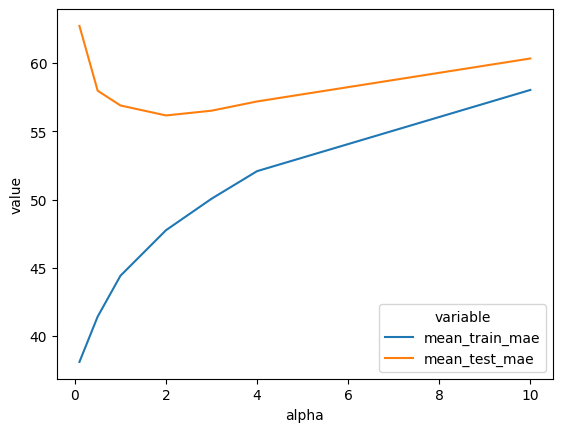

,alpha,mean_train_mae,mean_test_mae
0,0.1,38.103286,62.724174
1,0.5,41.424363,57.976270
2,1,44.417298,56.895861
3,2,47.754762,56.163828
4,3,50.060852,56.512038
5,4,52.083143,57.190029
6,10,58.033392,60.337918


In [17]:
param_grid_lasso = {
    'model__alpha': [0.1, 0.5, 1, 2, 3, 4, 10],
}

lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, Lasso(), continuous_preprocessor, categorical_preprocessor, param_grid_lasso, main_parameter='alpha')
lasso_model_hyperparam_tuning_df

Chosen alpha: 1

### Ridge

Fitting 15 folds for each of 8 candidates, totalling 120 fits


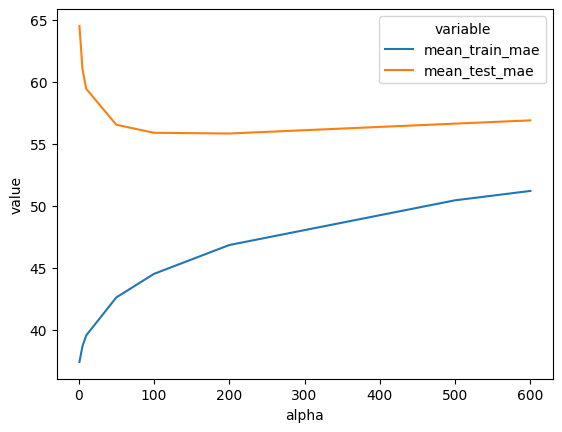

,alpha,mean_train_mae,mean_test_mae
0,1,37.413374,64.500115
1,5,38.677579,61.023545
2,10,39.550875,59.433555
3,50,42.614708,56.533328
4,100,44.511782,55.885112
5,200,46.836179,55.827248
6,500,50.442018,56.624161
7,600,51.198200,56.886838


In [19]:
param_grid_ridge = {
    "model__alpha": [1, 5, 10, 50, 100, 200, 500, 600],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, Ridge(), continuous_preprocessor, categorical_preprocessor, param_grid_ridge, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

Chosen alpha: 50

### RandomForest

In [30]:
param_grid_rf = {
    'model__n_estimators': [200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [8, 10, 12],
    'model__min_samples_leaf': [3, 5, 7],
}

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf, y_train_igf, IGF, RandomForestRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 18 candidates, totalling 270 fits


,params,mean_train_mae,mean_test_mae
16,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 10, 'model__n_estimators': 200}",41.810143,60.099159
9,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 200}",31.832130,60.177599
1,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 200}",33.928776,60.182291
10,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 200}",33.874325,60.235325
3,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 8, 'model__n_estimators': 200}",37.041478,60.241482
4,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}",36.968499,60.250744
6,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 8, 'model__n_estimators': 200}",41.863576,60.289191
13,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}",36.979434,60.297108
14,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 12, 'model__n_estimators': 200}",38.359807,60.302342
5,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 12, 'model__n_estimators': 200}",38.378933,60.303784


In [11]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=13)

tuned_df = compare_random_states(X_train_igf, y_train_igf, rf_model, IGF, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:22<00:00,  5.68s/it]


,cv_mae
56,-60.252833
24,-60.319136
71,-60.389253
67,-60.390057
8,-60.415431


### DecisionTreeRegressor

In [10]:
param_grid_tree = {
    "model__criterion": ["squared_error", "absolute_error"],
    "model__max_depth": [5, 7, 10, 15],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 20, 25, 30],
    "model__min_samples_leaf": [10, 15, 20, 25],
    }

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf, y_train_igf, IGF, DecisionTreeRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_tree)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 128 candidates, totalling 1920 fits


,params,mean_train_mae,mean_test_mae
60,"{'model__criterion': 'squared_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",57.744918,64.820633
12,"{'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",57.560372,64.921653
124,"{'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",56.128836,65.008289
126,"{'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 25, 'model__splitter': 'random'}",56.347978,65.039668
70,"{'model__criterion': 'absolute_error', 'model__max_depth': 5, 'model__min_samples_leaf': 15, 'model__min_samples_split': 25, 'model__splitter': 'random'}",54.164183,65.175315
105,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 20, 'model__splitter': 'random'}",54.071129,65.201847
14,"{'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 25, 'model__splitter': 'random'}",58.028373,65.317146
106,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 25, 'model__splitter': 'random'}",54.157504,65.367604
63,"{'model__criterion': 'squared_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 30, 'model__splitter': 'random'}",57.440324,65.409121
13,"{'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}",58.314826,65.413862


In [12]:
model = DecisionTreeRegressor(criterion="squared_error", max_depth=15, min_samples_leaf=25, min_samples_split=15, splitter='random')
	
tuned_df = compare_random_states(X_train_igf, y_train_igf, model, IGF, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [00:42<00:00,  2.31it/s]


,cv_mae
16,-63.625855
45,-63.926099
81,-64.088162
88,-64.180902
73,-64.462722


## Best models - IGF

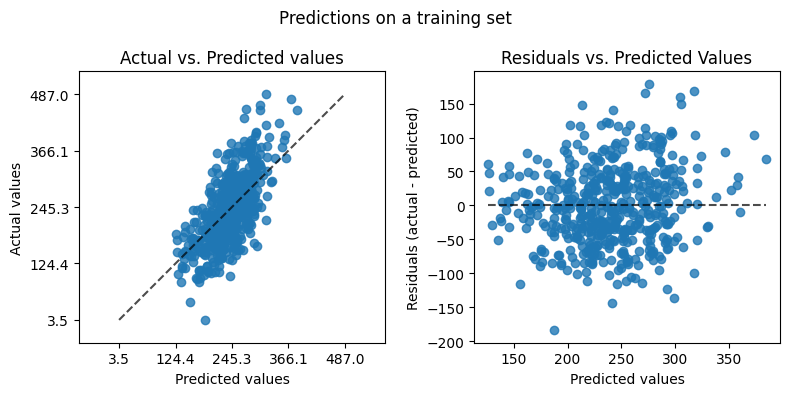

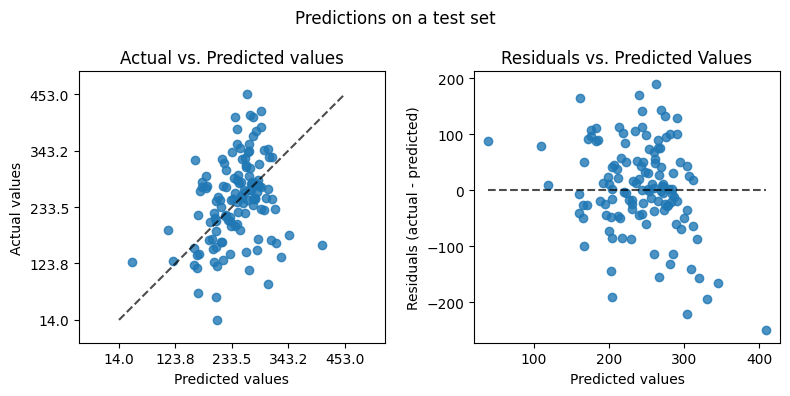

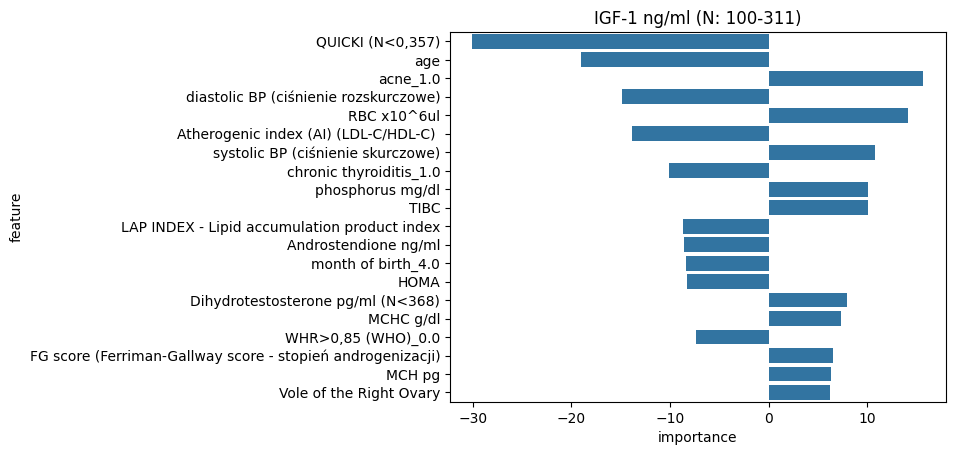

,model,data_set,mse,mae,rmse,r2
0,Lasso(alpha=1),training,3281.536,46.180,57.285,0.446
1,Lasso(alpha=1),test,6655.846,62.057,81.583,0.017


In [8]:
lasso_model = Lasso(alpha=1)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

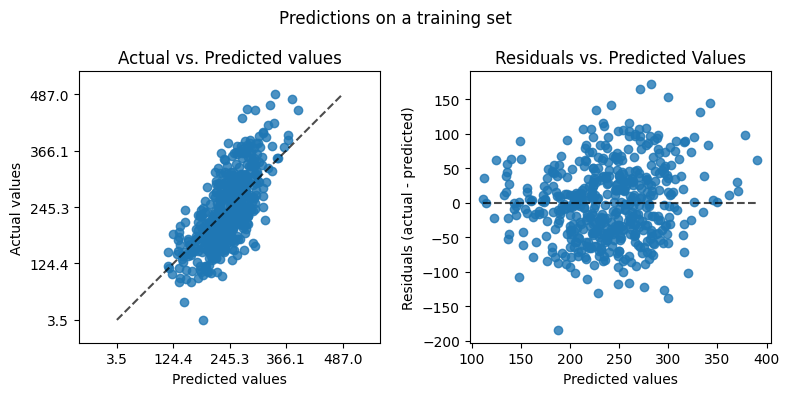

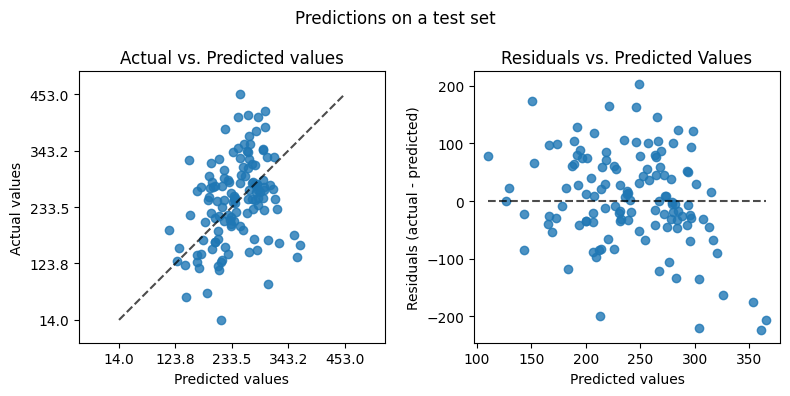

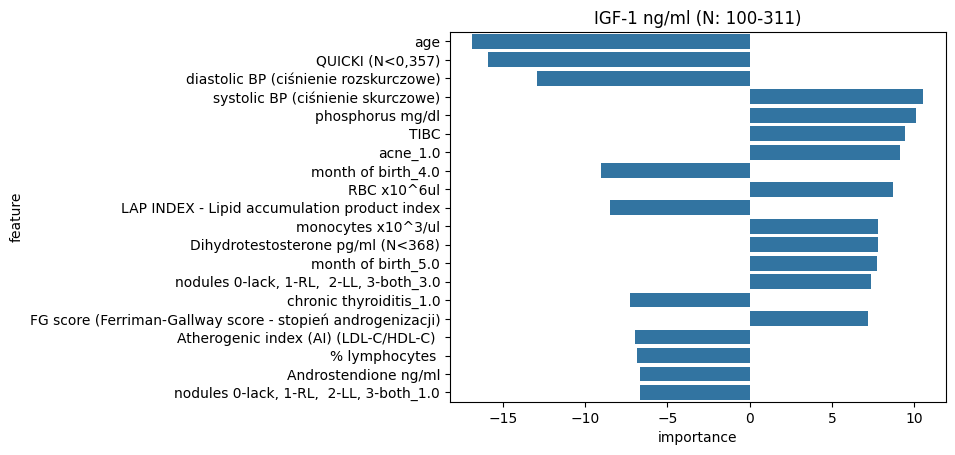

,model,data_set,mse,mae,rmse,r2
0,Ridge(alpha=50),training,2989.331,43.881,54.675,0.495
1,Ridge(alpha=50),test,6681.848,63.614,81.743,0.013


In [9]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

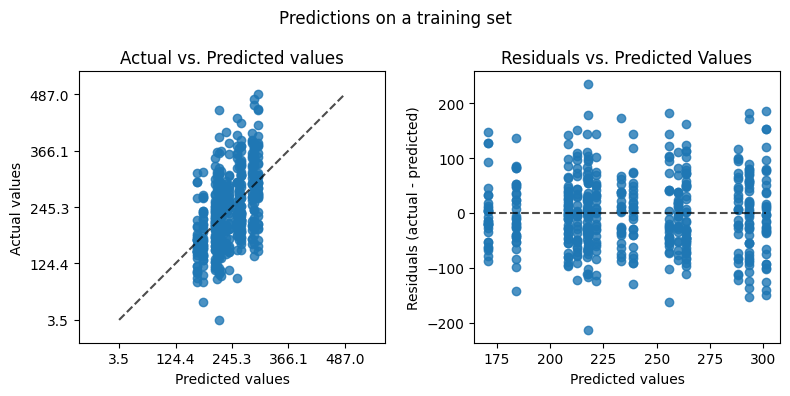

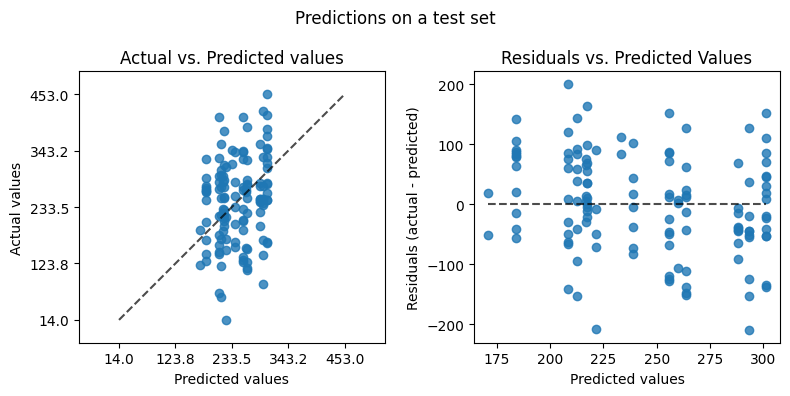

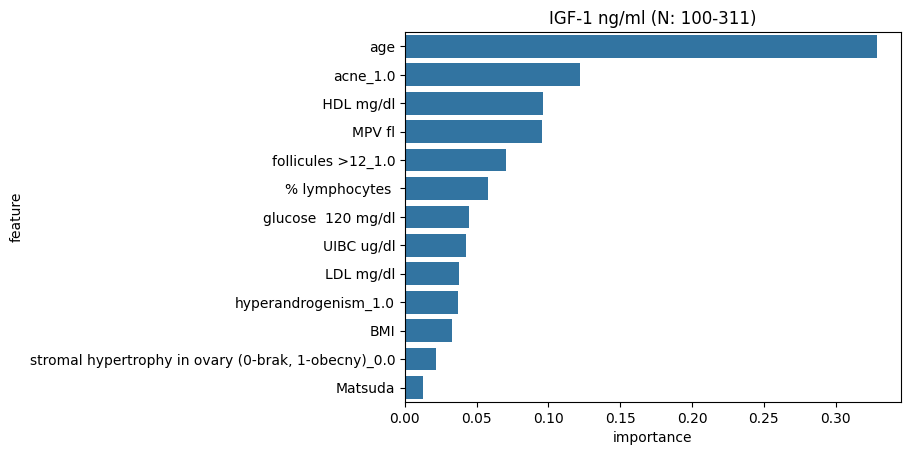

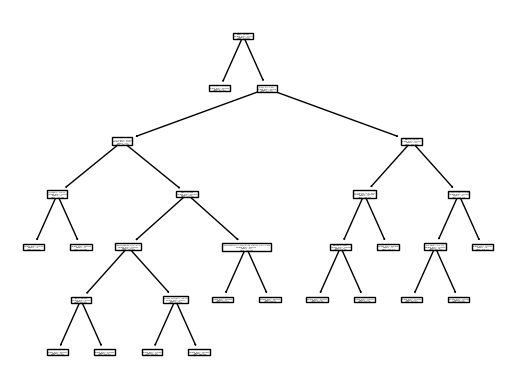

,model,data_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(max_depth=15, min_samples_leaf=25, min_samples_split=15,\n random_state=16, splitter='random')",training,4440.900,52.848,66.640,0.250
1,"DecisionTreeRegressor(max_depth=15, min_samples_leaf=25, min_samples_split=15,\n random_state=16, splitter='random')",test,6864.019,67.254,82.849,-0.014


In [28]:
tree_model = DecisionTreeRegressor(criterion="squared_error", max_depth=15, min_samples_leaf=25, min_samples_split=15, splitter='random', random_state=16)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, tree_continuous_preprocessor, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

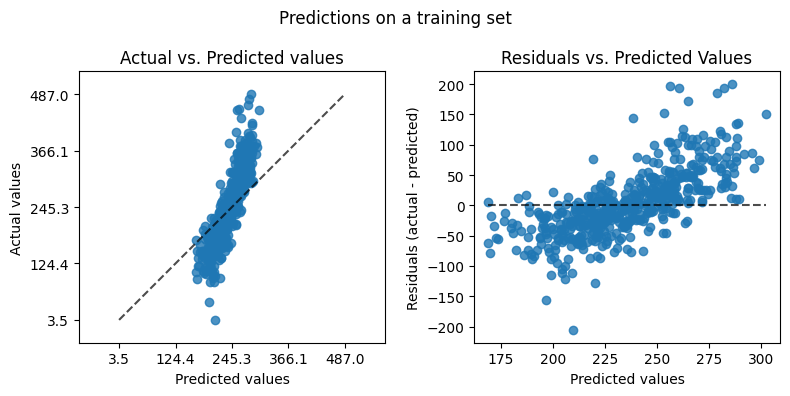

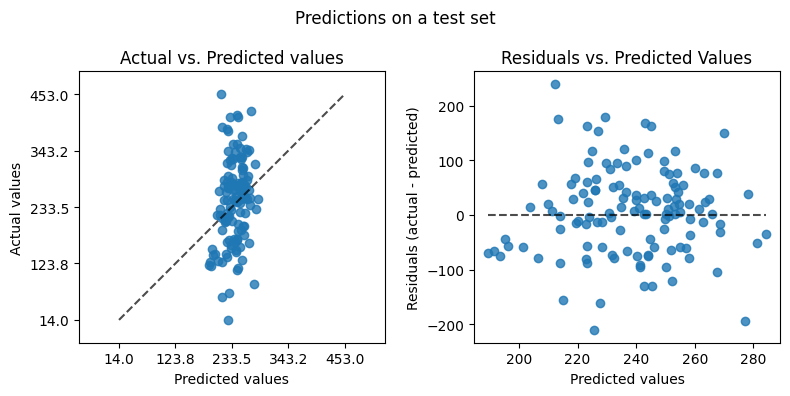

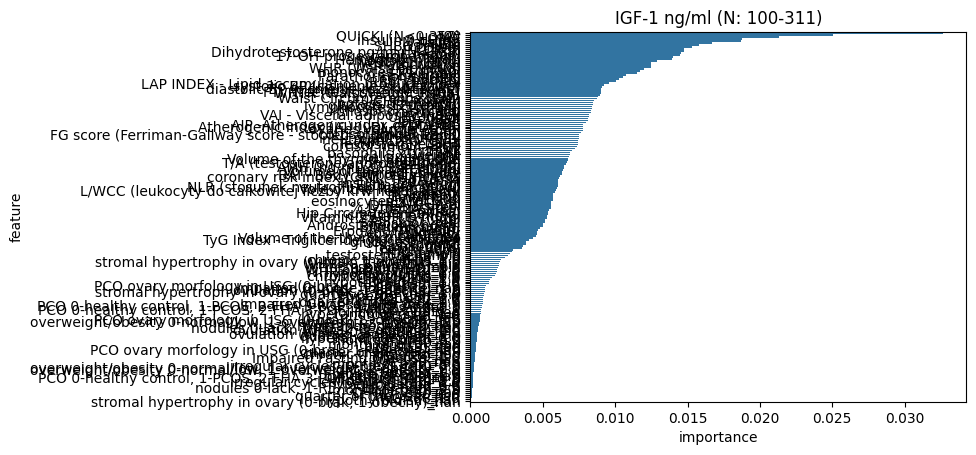

,model,data_set,mse,mae,rmse,r2
0,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=7, min_samples_split=10,\n n_estimators=200, random_state=56)",training,2990.503,41.217,54.685,0.495
1,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=7, min_samples_split=10,\n n_estimators=200, random_state=56)",test,6377.704,62.101,79.861,0.058


In [29]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56)
vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, tree_continuous_preprocessor, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df

### Feature importances

In [13]:
rename_importnace_col(feature_importnces_lasso, 'lasso')
rename_importnace_col(feature_importnces_ridge, 'ridge')
rename_importnace_col(feature_importnces_tree, 'tree')
rename_importnace_col(feature_importnces_rf, 'rf')

feature_importance_df = merge_feature_importances([feature_importnces_lasso, feature_importnces_ridge, feature_importnces_tree, feature_importnces_rf])

ranked_df = rank_importances(feature_importance_df)
ranked_df.head(5)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
0,HDL mg/dl,74.0,198.0,4.0,84.0,90.00
1,% lymphocytes,74.0,18.0,13.0,56.0,40.25
2,% monocytes,74.0,200.0,13.0,103.0,97.50
3,% neutrophil,74.0,120.0,13.0,52.0,64.75
4,%basophils,61.0,66.0,13.0,112.0,63.00


In [14]:
ranked_df.sort_values(by='lasso_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
84,"QUICKI (N<0,357)",1.0,2.0,13.0,2.0,4.50
126,age,2.0,1.0,1.0,1.0,1.25
124,acne_1.0,3.0,7.0,3.0,113.0,31.50
136,diastolic BP (ciśnienie rozskurczowe),4.0,3.0,13.0,27.0,11.75
85,RBC x10^6ul,5.0,9.0,13.0,18.0,11.25
15,Atherogenic index (AI) (LDL-C/HDL-C),6.0,17.0,13.0,65.0,25.25
210,systolic BP (ciśnienie skurczowe),7.0,4.0,13.0,37.0,15.25
130,chronic thyroiditis_1.0,8.0,15.0,13.0,116.0,38.00
197,phosphorus mg/dl,9.0,5.0,13.0,24.0,12.75
96,TIBC,10.0,6.0,13.0,8.0,9.25


In [15]:
ranked_df.sort_values(by='ridge_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
126,age,2.0,1.0,1.0,1.0,1.25
84,"QUICKI (N<0,357)",1.0,2.0,13.0,2.0,4.50
136,diastolic BP (ciśnienie rozskurczowe),4.0,3.0,13.0,27.0,11.75
210,systolic BP (ciśnienie skurczowe),7.0,4.0,13.0,37.0,15.25
197,phosphorus mg/dl,9.0,5.0,13.0,24.0,12.75
96,TIBC,10.0,6.0,13.0,8.0,9.25
124,acne_1.0,3.0,7.0,3.0,113.0,31.50
176,month of birth_4.0,13.0,8.0,13.0,194.0,57.00
85,RBC x10^6ul,5.0,9.0,13.0,18.0,11.25
54,LAP INDEX - Lipid accumulation product index,11.0,10.0,13.0,19.0,13.25


In [16]:
ranked_df.sort_values(by='tree_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
126,age,2.0,1.0,1.0,1.0,1.25
70,P-LCR %,74.0,77.0,2.0,11.0,41.00
124,acne_1.0,3.0,7.0,3.0,113.0,31.50
0,HDL mg/dl,74.0,198.0,4.0,84.0,90.00
145,follicules >12_1.0,50.0,60.0,5.0,127.0,60.50
31,FT3 pmol/l,47.0,38.0,6.0,25.0,29.00
115,"WHR>0,85 (WHO)_0.0",17.0,34.0,7.0,129.0,46.75
129,chronic thyroiditis_0.0,74.0,54.0,8.0,132.0,67.00
67,Matsuda,74.0,68.0,9.0,7.0,39.50
155,hyperandrogenism_1.0,74.0,206.0,10.0,144.0,108.50


In [17]:
ranked_df.sort_values(by='rf_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
126,age,2.0,1.0,1.0,1.0,1.25
84,"QUICKI (N<0,357)",1.0,2.0,13.0,2.0,4.50
163,insulin 0 uU/ml,74.0,165.0,13.0,3.0,63.75
38,HOMA,14.0,92.0,13.0,4.0,30.75
6,17-OH-progesterone ng/ml,28.0,56.0,13.0,5.0,25.50
55,LDL mg/dl,74.0,101.0,13.0,6.0,48.50
67,Matsuda,74.0,68.0,9.0,7.0,39.50
96,TIBC,10.0,6.0,13.0,8.0,9.25
79,PDW fl,32.0,55.0,13.0,9.0,27.25
56,LDL mmol/l,74.0,100.0,13.0,10.0,49.25


In [18]:
ranked_df.sort_values(by='average_rank').head(15)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
126,age,2.0,1.0,1.0,1.0,1.25
84,"QUICKI (N<0,357)",1.0,2.0,13.0,2.0,4.50
96,TIBC,10.0,6.0,13.0,8.0,9.25
85,RBC x10^6ul,5.0,9.0,13.0,18.0,11.25
136,diastolic BP (ciśnienie rozskurczowe),4.0,3.0,13.0,27.0,11.75
197,phosphorus mg/dl,9.0,5.0,13.0,24.0,12.75
26,Dihydrotestosterone pg/ml (N<368),15.0,12.0,13.0,13.0,13.25
54,LAP INDEX - Lipid accumulation product index,11.0,10.0,13.0,19.0,13.25
210,systolic BP (ciśnienie skurczowe),7.0,4.0,13.0,37.0,15.25
142,ferritin ng/ml,21.0,21.0,13.0,26.0,20.25


## Feature selection methods

In [21]:
selector = VarianceThreshold(threshold=0.009)
selector.set_output(transform='pandas')
selector.fit_transform(X_train_igf)

kept_features_mask = selector.get_support()

print("Usunięte cechy:", [X_train_igf.columns[i] for i, keep in enumerate(kept_features_mask) if not keep])

Usunięte cechy: ['WHR (Waist/Hip ratio)', 'WHTR (Waist/Height Ratio)', 'basophils x10^3/ul', 'NRBC x10^3/ul', 'MPV/PLT', 'L/WCC (leukocyty do całkowitej liczby krwinek białych)', 'eos/leukocyty', 'QUICKI (N<0,357)', 'T/SHBG', 'Testosterone/DHT']


In [24]:

def feature_selection(feature_selection_model, X_train, y_train):
    preprocessor = ColumnTransformer(
        verbose_feature_names_out=False,
        transformers=[
            ('num', continuous_preprocessor, get_continuous_attributes_except(IGF)),
            ('cat', categorical_preprocessor, CATEGORICAL_ATTRIBUTES)
        ])
    pipeline = Pipeline([('preprocessor', preprocessor), ('feature_selection', feature_selection_model)])

    X_new = pipeline.fit_transform(X_train, y_train)

    selected_indices = feature_selection_model.get_support(indices=True)
    selected_feature_names = [preprocessor.get_feature_names_out()[i] for i in selected_indices]
    print(selected_feature_names)

    return pd.DataFrame(X_new, columns=selected_feature_names)


feature_selection(SelectKBest(mutual_info_regression, k=10), X_train_igf, y_train_igf)


feature_selection(SelectKBest(f_regression, k=10), X_train_igf, y_train_igf)


feature_selection(SelectKBest(r_regression, k=10), X_train_igf, y_train_igf).head()

['basophils x10^3/ul', 'L/WCC (leukocyty do całkowitej liczby krwinek białych)', 'coronary risk index (CRI) (TG/HDL-C)', 'TIBC', 'HOMA', 'Matsuda', 'QUICKI (N<0,357)', 'DHEA-S ug/dl', 'vitamin 25-OH D ng/ml', 'acne_0.0']
['Atherogenic index (AI) (LDL-C/HDL-C) ', 'coronary risk index (CRI) (TG/HDL-C)', 'VAI - Visceral adiposity index', 'LAP INDEX - Lipid accumulation product index', 'TIBC', 'ferritin ng/ml', 'Dihydrotestosterone pg/ml (N<368)', 'age', 'acne_0.0', 'acne_1.0']
['Hemoglobin [g/dl]', 'hematocrit [%]', 'phosphorus mg/dl', 'TIBC', 'FT3 pmol/l', '17-OH-progesterone ng/ml', 'Dihydrotestosterone pg/ml (N<368)', 'acne_1.0', 'hyperlipidemia_nan', 'CHOL>200_nan']


,Hemoglobin [g/dl],hematocrit [%],phosphorus mg/dl,TIBC,FT3 pmol/l,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),acne_1.0,hyperlipidemia_nan,CHOL>200_nan
0,-0.538462,-0.558824,-1.069620,1.180328,0.124700,-0.830769,-0.906414,0.0,0.0,0.0
1,-0.846154,-0.323529,-0.208861,0.901639,-0.556355,-0.846154,-0.813880,0.0,0.0,0.0
2,-0.307692,-0.558824,0.740506,-0.229508,-0.824940,0.446154,-0.691903,1.0,0.0,0.0
3,0.384615,0.264706,0.284810,0.540984,0.719424,0.761538,-0.599369,0.0,0.0,0.0
4,-0.692308,-0.352941,0.145570,-0.540984,-0.019185,0.076923,-0.788644,1.0,0.0,0.0


Optimal number of features: 16
['systolic BP (ciśnienie skurczowe)'
 'diastolic BP (ciśnienie rozskurczowe)' 'RBC x10^6ul' 'MCH pg'
 'phosphorus mg/dl' 'Atherogenic index (AI) (LDL-C/HDL-C) ' 'TIBC' 'HOMA'
 'QUICKI (N<0,357)' 'age' 'WHR>0,85 (WHO)_1.0' 'WHR>0,8 (NIDDK)_0.0'
 'acne_1.0' 'chronic thyroiditis_1.0' 'Impaired Glucose Tolerance_nan'
 'month of birth_4.0']


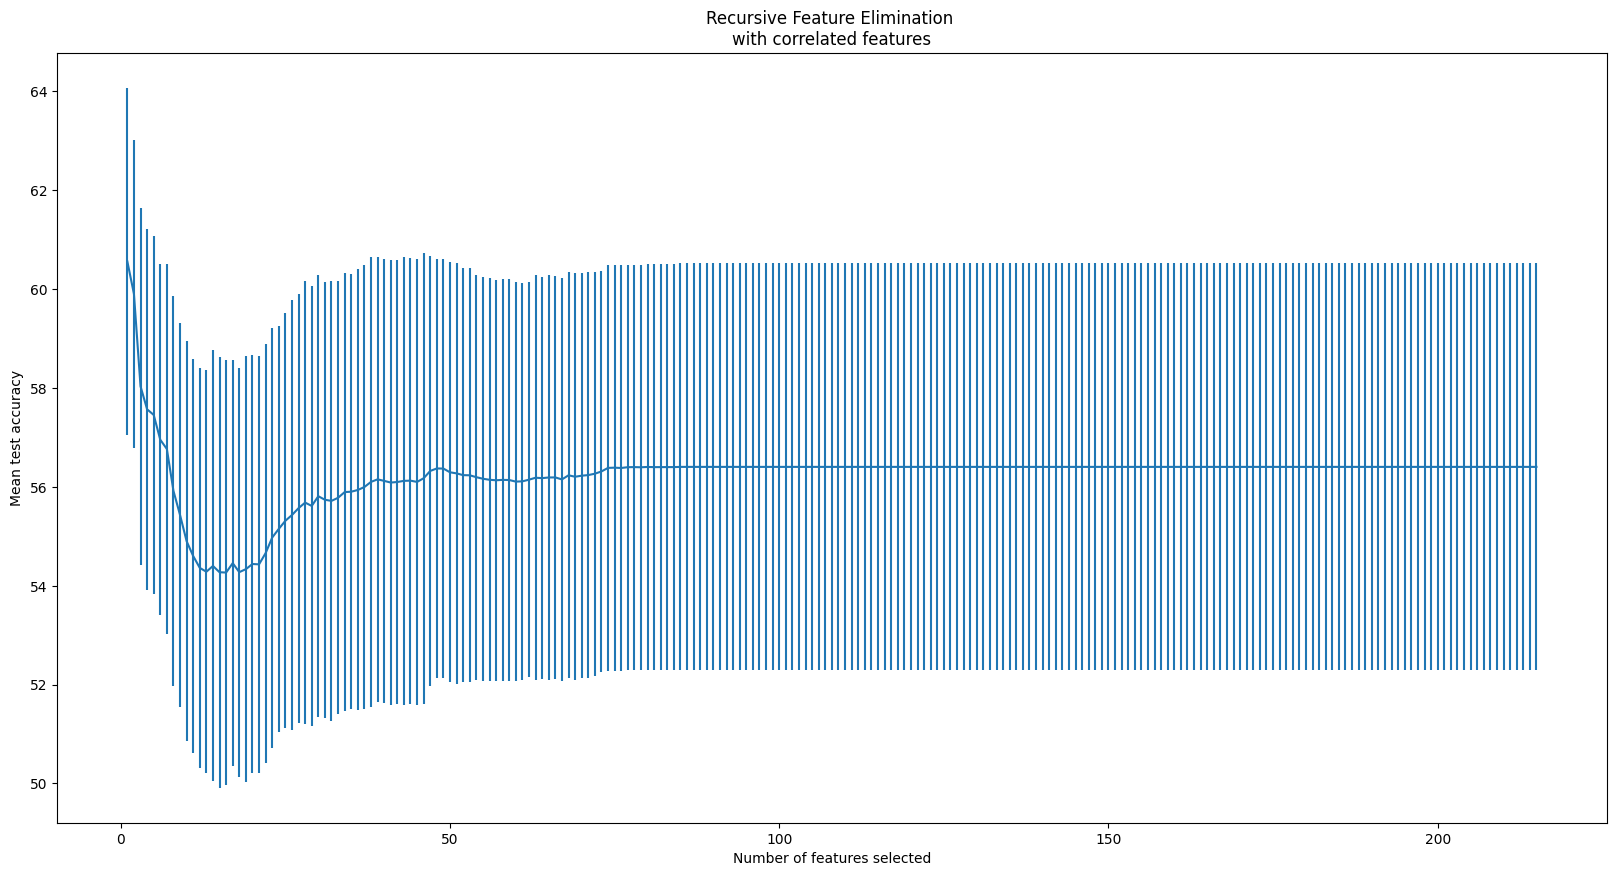

In [25]:
preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ('num', continuous_preprocessor, get_continuous_attributes_except(IGF)),
        ('cat', categorical_preprocessor, CATEGORICAL_ATTRIBUTES)
    ])


min_features_to_select = 1
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
rfecv = RFECV(
    estimator=Lasso(),
    step=1,
    cv=cv,
    scoring="neg_mean_absolute_error",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

pipeline = Pipeline([('preprocessor', preprocessor), ('fs', rfecv)])
pipeline.fit(X_train_igf, y_train_igf)

selected_feature_indices = rfecv.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]

# print(len(preprocessor.get_feature_names_out()))
print(f"Optimal number of features: {rfecv.n_features_}")
# print(rfecv.get_feature_names_out())
print(selected_feature_names)

n_scores = len(rfecv.cv_results_["mean_test_score"])
scores = abs(rfecv.cv_results_["mean_test_score"])

plt.figure(figsize=(20,10))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    scores,
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
sel_from_model = SelectFromModel(
    estimator=Lasso(),
)

pipeline = Pipeline([('preprocessor', preprocessor), ('sel_from_model', sel_from_model)])
pipeline.fit(X_train_igf, y_train_igf)

selected_feature_indices = sel_from_model.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
selected_feature_names

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=3)
tpot = TPOTRegressor(generations=5, population_size=50, cv=cv, verbosity=2, random_state=42, scoring='r2', n_jobs=-1)
tpot.fit(X_train_igf, y_train_igf)

print(tpot.fitted_pipeline_)

print("Score on test set:", tpot.score(X_test_igf, y_test_igf))

tpot.export('tpot_pipeline.py')

In [ ]:

cv = RepeatedKFold(n_splits=5, n_repeats=3)
tpot = TPOTRegressor(generations=5, population_size=50, cv=cv, verbosity=2, random_state=42, scoring='neg_mean_absolute_error', n_jobs=-1)
tpot.fit(X_train_igf, y_train_igf)

# Wyświetlenie najlepszego znalezionego rurociągu
print(tpot.fitted_pipeline_)

# Ocena modelu na zbiorze testowym
print("Score on test set:", tpot.score(X_test_igf, y_test_igf))

# Eksportowanie optymalnego rurociągu do pliku Pythona
tpot.export('tpot_pipeline.py')